# Adaptive PDE discretizations on cartesian grids : Algorithmic tools

## Part : Automatic differentiation
## Chapter : Dense automatic differentiation, and geodesic shooting

We illustrate dense automatic differentiation, both first and second order, with an application to geodesic shooting.
For that purpose we consider Hamilton's equations of geodesics, reading
$$
    \dot q = \partial_p H(q,p), \qquad \dot p = -\partial_q H(q,p),
$$
where $H$ is the *Hamiltonian* of the medium. Following the classical convention we denote by 
* $q$ the position variable,
* $p$ the impultion, which is dual to the velocity.

**Riemannian Hamiltonian.** For a domain $\Omega \subset R^d$ equipped with a Riemannian metric $M : \Omega \to S_d^{++}$, the Hamiltonian is defined as 
$$
    H(q,p) := \frac 1 2 \|p\|_{D(q)}^2, \quad \text{where} D(q) := M(q)^{-1}.
$$

**Poincaré's half plane model.** 
We illustrate this ODE in the case of Poincaré's half plane model of the hyperbolic space, defined by the Riemannian metric
$$
    M(q) := \frac{\rm Id}{q_1^2},
$$
where $q = (q_0,q_1) \in \Omega = R \times R^{++}$. Thus $H(q,p) = (q_1^2/2) \|p\|^2$. 

**Exponential map.**
We also consider the Riemannian metric on $R^2 \setminus \{0\}$ defined by
$$
    M(q) := \frac{\rm Id}{q^2}.
$$
It can be regarded as the metric induced by the logarithmic (multivalued) map $\ln : C \setminus \{0\} \to C$, where the targer space $C$ is equipped with the usual norm, and it possesses periodic trajectories.

<!---
**Symplectic integrators**
In this notebook, we solve the equations of geodesics using a standard Runge-Kutta scheme. This may sound as a heresy since these equations benefit from a Hamiltonian structure, and can thus be solved more stably using a symplectic integrator, in principle. However, our Hamiltonians are *non-separable*, in other words they do *not* take the form 
$$
    H(q,p) = F(p) + V(q).
$$
For this reason, the implementation details of a symplectic scheme are non-trivial, and we thus stick to a standard ODE scheme.
--->

In [99]:
import sys; sys.path.append("../..") # Allow imports from parent directory

In [100]:
from Miscellaneous import TocTools; TocTools.displayTOC('Dense','Algo')

[**Summary**](Summary.ipynb) of this series of notebooks. [(view online)](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks_Algo/Dense.ipynb)

[**Main summary**](../Summary.ipynb), including the other volumes of this work. [(view online)](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Summary.ipynb)


# Table of contents

  * [1. Automatic differentiation basics](#1.-Automatic-differentiation-basics)
    * [1.1 Differentiating a function](#1.1-Differentiating-a-function)
    * [1.2 Differentiating w.r.t several variables](#1.2-Differentiating-w.r.t-several-variables)
    * [1.3 Vectorization](#1.3-Vectorization)
    * [1.4 Second order automatic differentiation](#1.4-Second-order-automatic-differentiation)
  * [2. Shooting geodesics](#2.-Shooting-geodesics)
    * [2.1 Explicit Euler scheme](#2.1-Explicit-Euler-scheme)
    * [2.1 High order explicit schemes](#2.1-High-order-explicit-schemes)
    * [2.2 Symplectic Euler scheme](#2.2-Symplectic-Euler-scheme)




**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay


## 0. Importing the required libraries

In [101]:
from NumericalSchemes import AutomaticDifferentiation as ad

In [102]:
import numpy as np
from matplotlib import pyplot as plt

In [103]:
def reload_packages():
    import importlib
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)
    ad.Dense = importlib.reload(ad.Dense)
    ad.Sparse2 = importlib.reload(ad.Sparse2)
    ad.Dense2 = importlib.reload(ad.Dense2)

**Implementation note.** The type `numpy.float64` often causes trouble due to bad operator priority (when multiplied with an array of shape `()` and containing automatic differentiation information). We circumvent this issue using the function ad.to_array which casts any value of to a numpy array, in this case to an array containing a single element and of shape $()$ (the empty tuple).

In [104]:
def H_HalfPlane(q,p):
    return ad.to_array(0.5*q[1]**2)*(p**2).sum(axis=0)
def H_Log(q,p):
    return ad.to_array(0.5*(q**2).sum(axis=0))*((p**2).sum(axis=0))

## 1. Automatic differentiation basics

We illustrate the automatic differentiation mechanism by differentiating a Hamiltonian w.r.t. the position $q$ and momentum $p$, which is a prerequisite for implementing Hamilton's ODE of motion.

### 1.1 Differentiating a function

In [105]:
Hamiltonian = H_HalfPlane

In [106]:
q = np.array([0.,1.])
p = np.array([1.,1.])

In [107]:
Hamiltonian(q,p)

1.0

In order access the Hamiltonian's derivatives, say with respect to position, we evaluate it on a variable featuring first order information. Said otherwise, we create a variable representing the first order Taylor expansion
$$
    q_{\rm ad} = (q_0+\delta_0,q_1+\delta_1) + O(\|\delta\|^2),
$$
where $\delta = (\delta_0,\delta_1)$ is a symbolic, infinitesimal perturbation.

In [108]:
q_ad = ad.Dense.identity(constant=q)

In [109]:
q_ad # Contains an additional array representing first order information.

denseAD(array([0., 1.]),
array([[1., 0.],
       [0., 1.]]))

In [110]:
print("Zero-th order : ",q_ad.value)
print("First order : \n",q_ad.coef)

Zero-th order :  [0. 1.]
First order : 
 [[1. 0.]
 [0. 1.]]


The first order information is propagated through the computations, and eventually we obtain the result
$$
    H(q_{\rm ad},p) = H(q,p) + <\nabla_q H(q,p),\delta> + O(\|\delta\|^2).
$$
Note that, for Poincaré's half plane model, one has $\nabla_q H(q,p) = (0,q_1 \|p\|^2)$.

In [111]:
Hamiltonian(q_ad,p)

denseAD(array(1.),array([0., 2.]))

In [112]:
print("Gradient of the Hamiltonian w.r.t. the variable q : ",Hamiltonian(q_ad,p).coef)

Gradient of the Hamiltonian w.r.t. the variable q :  [0. 2.]


We can similarly differentiate w.r.t. the momentum $p$. Poincaré's half plane model obeys
$\nabla_p H(q,p) = q_1^2 p$.

In [113]:
p_ad = ad.Dense.identity(constant=p)
Hamiltonian(q,p_ad)

denseAD(array(1.),array([1., 1.]))

### 1.2 Differentiating w.r.t several variables

Evaluating $H(q_{\rm ad},p_{\rm ad})$ yields an result may sound unexpected: we obtain the sum $\nabla_q H(q,p)+\nabla_p H(q,p)$ of the gradients, instead of their independent values. Indeed, this follows from the first order Taylor expansion
$$
H(q+\delta,p+\delta) = 
H(q,p) + <\nabla_q H(q,p),\delta> + <\nabla_p H(q,p),\delta> + O(\|\delta\|^2),
$$
where $\delta = (\delta_0,\delta_1)$ is an infinitesimal symbolic perturbation.

In [114]:
reload_packages()

In [115]:
Hamiltonian(q_ad,p_ad)

denseAD(array(1.),array([1., 3.]))

In order to obtain the gradient of $H$ w.r.t the independent variables $q$ and $p$, we need to specify that the corresdponding infinitesimal perturbations are independent. Namely set
$$
    q_{\rm ad} = q+(\delta_0,\delta_1), \quad p_{\rm ad} = p+(\delta_2,\delta_3),
$$
where $(\delta_0,\cdots,\delta_4)$ is four dimensional infinitesimal perturbation.

In [116]:
q_ad = ad.Dense.identity(constant=q,shift=(0,p.size))
p_ad = ad.Dense.identity(constant=p,shift=(q.size,0))

As desired, we obtain the full gradient of $H$, which is the concatenation of $\nabla_q H$ and $\nabla_p H$.

In [117]:
Hamiltonian(q_ad,p_ad)

denseAD(array(1.),array([0., 2., 1., 1.]))

In [118]:
q_ad

denseAD(array([0., 1.]),
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]]))

In [119]:
p_ad

denseAD(array([1., 1.]),
array([[0., 0., 1., 0.],
       [0., 0., 0., 1.]]))

### 1.3 Vectorization

A common programming style in Python application to numerics is vectorized computations using numpy tensors.
This allows avoiding loops, when some operation has to be repeated a large number of times, with improvements in clarity, flexibility, and speed. 

As an example, we compute $H(q_0,p_0)$, $H(q_1,p_1)$, $H(q_2,p_2)$, where $q_0,q_1,q_2$ and $p_0,p_1,p_2$ are different positions and impulsions. We also differentiate these values w.r.t. the impulsion.

In [120]:
q0 = np.array([0.,1.]); q1 = np.array([1.,1.]); q2 = np.array([-2.,1.]); 
p0 = np.array([1.,1.]); p1 = np.array([1.,0.]); p2 = np.array([-1.,-1.]); 

In [121]:
Hamiltonian(q0,p0), Hamiltonian(q1,p1), Hamiltonian(q2,p2) 

(1.0, 0.5, 1.0)

In [122]:
Ham_seq = [Hamiltonian(q,ad.Dense.identity(constant=p)) for (q,p) in ((q0,p0), (q1,p1), (q2,p2))]
Ham_seq

[denseAD(array(1.),array([1., 1.])),
 denseAD(array(0.5),array([1., 0.])),
 denseAD(array(1.),array([-1., -1.]))]

The vectorized form of these computations is as follows.

In [123]:
q_vec = np.stack( (q0,q1,q2),axis=1)
p_vec = np.stack( (p0,p1,p2),axis=1)

In [124]:
Hamiltonian(q_vec,p_vec)

array([1. , 0.5, 1. ])

In [125]:
p_vec_ad = ad.Dense.identity(constant=p_vec)

However, the automatic differentiation result may not be what is desired. Indeed, the entries of `q_vec` are all considered independent, and we recover a six dimensional gradient vector for each component. This is both impractical and numerically expensive.

In [126]:
Ham_vec = Hamiltonian(q_vec,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0., -1.]]))

In [127]:
print("Sequential result : ",Ham_seq[0])
print("Vectorized result : ",Ham_vec[0])

Sequential result :  denseAD(1.0,[1. 1.])
Vectorized result :  denseAD(1.0,[1. 0. 0. 1. 0. 0.])


In this situation, and in contrast with the previous section, we would like the perturbations to be regarded as dependent. This is achieved with the following parameters:
* `shape_free` : apply free independent symbolic perturbations w.r.t. these dimensions.
* `shape_bound` : apply bound correlated symbolic perturbations w.r.t. these dimensions.

It is assumed that the *free* dimensions come first, and the *bound* dimensions come last. Only one of the two parameters `shape_free` and `shape_bound` needs to be specified, since they are redundant.

In [128]:
p_vec.shape

(2, 3)

The first dimension is *free*, and the last one is *bound* since it is only introduced for vectorization purposes.

In [129]:
shape_free,shape_bound = p_vec.shape[:1], p_vec.shape[-1:]

In [130]:
p_vec_ad = ad.Dense.identity(constant=p_vec, shape_bound=shape_bound)
#p_vec_ad = ad.Dense.identity(constant=p_vec, shape_free=shape_free) # Equivalently

In [131]:
Ham_vec = Hamiltonian(q_vec,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 1.,  1.],
       [ 1.,  0.],
       [-1., -1.]]))

In [132]:
print("Vectorized result (with shape_bound): ",Ham_vec[0])

Vectorized result (with shape_bound):  denseAD(1.0,[1. 1.])


This technique is compatible with differentiation w.r.t. multiple independent variables.

In [133]:
q_vec_ad = ad.Dense.identity(constant=q_vec, shape_free=shape_free, shift=(0,len(p_vec)) )
p_vec_ad = ad.Dense.identity(constant=p_vec, shape_free=shape_free, shift=(len(q_vec),0) )

In [134]:
Ham_vec = Hamiltonian(q_vec_ad,p_vec_ad)
Ham_vec

denseAD(array([1. , 0.5, 1. ]),
array([[ 0.,  2.,  1.,  1.],
       [ 0.,  1.,  1.,  0.],
       [ 0.,  2., -1., -1.]]))

In [135]:
print("Full gradient w.r.t q0,p0 : ", Ham_vec[0])

Full gradient w.r.t q0,p0 :  denseAD(1.0,[0. 2. 1. 1.])


### 1.4 Second order automatic differentiation

There are situations where second order automatic differentiation is needed. It could be achieved, in principle, by recursive calls to first order differentiation. However, for reasons of performance and convenience, a dedicated class is implemented.

In [136]:
q_ad = ad.Dense2.identity(constant=q)

The hessian of Poincaré's half plane model hamiltonian, w.r.t. position is 
$$
    \nabla_q H(q,p) = \begin{pmatrix} 0 & 0 \\ 0 & \|p\|^2 \end{pmatrix}
$$
and w.r.t. impulsion
$$
    \nabla_p H(q,p) = q_0^2 {\rm Id}.
$$

In [137]:
Ham = Hamiltonian(q_ad,p)
Ham

denseAD2(array(1.),array([0., 2.]),
array([[0., 0.],
       [0., 2.]]))

In [138]:
print("Function value : ", Ham.value)
print("Gradient : ", Ham.coef1)
print("Hessian : \n", Ham.coef2)

Function value :  1.0
Gradient :  [0. 2.]
Hessian : 
 [[0. 0.]
 [0. 2.]]


In [139]:
p_ad = ad.Dense2.identity(constant=p)

In [140]:
Hamiltonian(q,p_ad)

denseAD2(array(1.),array([1., 1.]),
array([[1., 0.],
       [0., 1.]]))

A joint hessian, of size $4\times 4$, can be computed. 

In [141]:
q_ad = ad.Dense2.identity(constant=q, shift=(0,p.size))
p_ad = ad.Dense2.identity(constant=p, shift=(q.size,0))

In [142]:
p_ad.coef2.shape

(2, 4, 4)

In [143]:
Hamiltonian(q_ad,p_ad)

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

Vectorization works as in the first order case.

In [144]:
q_vec_ad = ad.Dense2.identity(constant=q_vec, shape_free=shape_free)

In [145]:
Ham = Hamiltonian(q_vec_ad,p_vec)
Ham[0]

denseAD2(array(1.),array([0., 2.]),
array([[0., 0.],
       [0., 2.]]))

In [146]:
q_vec_ad = ad.Dense2.identity(constant=q_vec,shape_bound=shape_bound, shift=(0,len(p_vec)) )
p_vec_ad = ad.Dense2.identity(constant=p_vec,shape_bound=shape_bound, shift=(len(q_vec),0) )

In [147]:
Ham = Hamiltonian(q_vec_ad,p_vec_ad)
Ham[0]

denseAD2(array(1.),array([0., 2., 1., 1.]),
array([[0., 0., 0., 0.],
       [0., 2., 2., 2.],
       [0., 2., 1., 0.],
       [0., 2., 0., 1.]]))

## 2. Shooting geodesics

We implement Hamilton's equations of motion
$$
    \dot q = \partial_p H(q,p), \qquad \dot p = -\partial_q H(q,p),
$$
using several numerical schemes.

**Conserved quantity.**
By construction, the Hamiltonian value is conserved along the Hamiltonian flow:
$$
    H(q(t),p(t)) = {\rm cst},
$$
if $t \mapsto (q(t),p(t))$ is a solution to Hamilton's equations of motion.

**Explicit solution for the half plane model.**
The geodesics for the Poincare half plane model are known explicitly. They are half circles whose center lies on the horizontal axis.

### 2.1 Explicit Euler scheme

The simplest of all ODE solvers reads
$$
    \frac{q_{n+1}-q_n} {\Delta t} = \partial_p H(q_n,p_n), \qquad \frac{p_{n+1}-p_n} {\Delta t} = -\partial_q H(q_n,p_n),
$$
where $(q_0,p_0)$ is a given initial condition, and $n>0$ is the iteration number, and $\Delta t$ is the time step.

In [148]:
def EulerStep(q,p,H,dt):
    d=len(q)
    q_ad = ad.Dense.identity(constant=q,shape_free=(d,),shift=(0,d))
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,),shift=(d,0))
    grad = np.moveaxis(H(q_ad,p_ad).coef,-1,0)
    return q+dt*grad[d:],p-dt*grad[:d]

def Geodesic(q0,p0,H,t,n=100,step=EulerStep):
    dt=t/n
    q,p=q0.copy(),p0.copy()
    Q,P=[q],[p]
    for i in range(n):
        q,p=step(q,p,H,dt)
        Q.append(q)
        P.append(p)
    return ad.stack(Q,axis=-1),ad.stack(P,axis=-1),np.linspace(0,t,n+1)

In [149]:
grad = EulerStep(q_vec,p_vec,Hamiltonian,0.1)

Euler's explicit scheme is only first order accurate. While the geodesic circular shape is more or less observed, the Hamiltonian conservation is far from perfect.

In [150]:
Q,P,T = Geodesic(q_vec,p_vec,Hamiltonian,4.)
# For convenience, we put time as a second coordinate.
Q,P = [np.moveaxis(arr,-1,1) for arr in (Q,P)] 

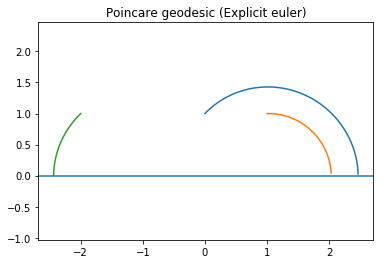

In [151]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit euler)")
plt.plot(Q[0],Q[1]); plt.axhline(0);

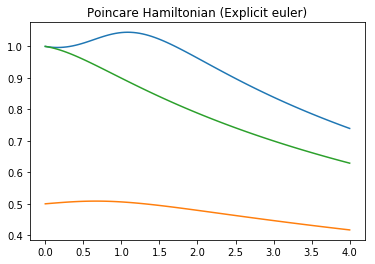

In [152]:
plt.title("Poincare Hamiltonian (Explicit euler)")
plt.plot(T,Hamiltonian(Q,P));

### 2.1 High order explicit schemes

A natural approach to improve the ODE solver is to increase its consistency order. This can be achieved using Runge-Kutta methods, here of second and fourth order.

In [153]:
def SymplecticGradient(q,p,H):
    d=len(q)
    q_ad = ad.Dense.identity(constant=q,shape_free=(d,),shift=(0,d))
    p_ad = ad.Dense.identity(constant=p,shape_free=(d,),shift=(d,0))
    grad = np.moveaxis(H(q_ad,p_ad).coef,-1,0)
    return grad[d:],-grad[:d]

def RK2Step(q,p,H,dt):
    k1 = SymplecticGradient(q,p,H)
    k2 = SymplecticGradient(q+0.5*dt*k1[0],p+0.5*dt*k1[1],H)
    return q+dt*k2[0],p+dt*k2[1]

def RK4Step(q,p,H,dt):
    k1 = SymplecticGradient(q,p,H)
    k2 = SymplecticGradient(q+0.5*dt*k1[0],p+0.5*dt*k1[1],H)
    k3 = SymplecticGradient(q+0.5*dt*k2[0],p+0.5*dt*k2[1],H)
    k4 = SymplecticGradient(q+dt*k3[0],p+dt*k3[1],H)
    return q+dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6.,p+dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6.

In [154]:
Q2,P2,T = Geodesic(q_vec,p_vec,Hamiltonian,4.,step=RK2Step)
Q2,P2 = [np.moveaxis(arr,-1,1) for arr in (Q2,P2)] 

In [155]:
Q4,P4,T = Geodesic(q_vec,p_vec,Hamiltonian,4.,step=RK4Step)
Q4,P4 = [np.moveaxis(arr,-1,1) for arr in (Q4,P4)] 

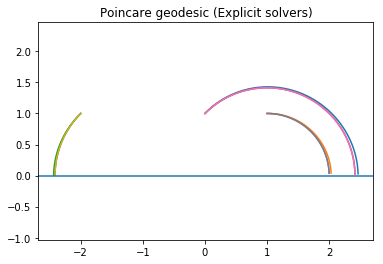

In [156]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit solvers)")
plt.plot(Q[0],Q[1], Q2[0],Q2[1], Q4[0],Q4[1]); plt.axhline(0);

The Hamiltonian is almost exactly constant for the second and fourth order models.

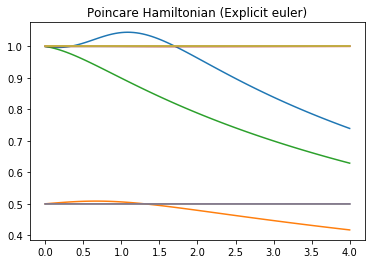

In [157]:
plt.title("Poincare Hamiltonian (Explicit euler)")
plt.plot(T,Hamiltonian(Q,P), T,Hamiltonian(Q2,P2), T,Hamiltonian(Q4,P4));

**Cone model.**
However, if the trajectory is long enough, and the time step is large enough, then even the high order models fail to conserve the Hamiltonian. This is evidenced with 

In [158]:
Hamiltonian = H_Log

In [159]:
q,p = np.array([1,0]),np.array([0,1])

In [160]:
Q,P,T = Geodesic(q,p,Hamiltonian,6.,step=EulerStep)
Q2,P2,T2 = Geodesic(q,p,Hamiltonian,25.,step=RK2Step)
Q4,P4,T4 = Geodesic(q,p,Hamiltonian,75.,step=RK4Step)

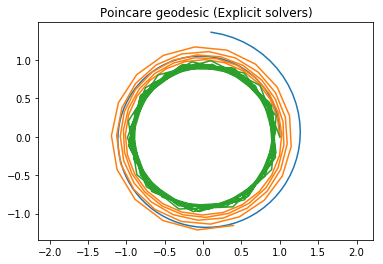

In [161]:
plt.axis('equal'); plt.title("Poincare geodesic (Explicit solvers)")
plt.plot(Q[0],Q[1], Q2[0],Q2[1], Q4[0],Q4[1]); 

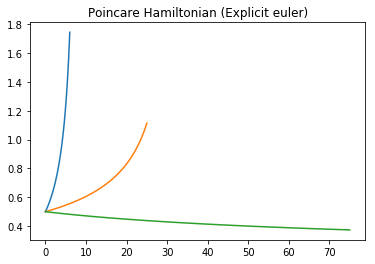

In [162]:
plt.title("Poincare Hamiltonian (Explicit euler)")
plt.plot(T,Hamiltonian(Q,P), T2,Hamiltonian(Q2,P2), T4,Hamiltonian(Q4,P4));

### 2.2 Symplectic Euler scheme

Symplectic schemes guarantee that a quantity, closely related with the Hamiltonian, is conserved along the trajectory. 

The Euler symplectic scheme is defined as follows:
$$
    \frac{q_{n+1}-q_n}{\Delta t} = \partial_p H(q_n,p_n), \quad
    \frac{p_{n+1}-p_n}{\Delta t} = \partial_q H(q_{n+1},p_{n+1}).
$$
Note that the scheme is semi-implicit, hence harder to implement.

**Separable Hamiltonians.** If the energy takes the form $H(q,p) = F(p) + V(q)$, then the Euler symplectic scheme becomes explicit. However, our specific choices do not fall in that category.

In [98]:
reload_packages()

In [75]:
def NewtonStep(p0,F,n=3):
    p_ad = ad.Dense.identity(constant=p0.copy(),shape_free=(len(p0),))
    for i in range(n):
        p_ad = p_ad+F(p_ad).solve()
    return p_ad.value

def SymplecticEulerStep(q0,p0,H,dt):
    d=len(q0)
    q_ad = ad.Dense.identity(constant=q0,shape_free=(d,))
    q=q0+dt*np.moveaxis(H(q_ad,p0).coef,-1,0)
    def F(p):
        nonlocal q,p0,dt
        p_ad = ad.Dense.identity(constant=p,shape_free=(d,))
        return p-p0+dt*np.moveaxis(H(q,p_ad).coef,-1,0)
    return q,NewtonStep(p0,F)

**TODO**
* Solve the += problem.
* Make recursive AD possible. (Probably using hack such as array of AD)

In [167]:
arr = np.zeros((2,),type(p_ad))

In [168]:
arr[0]=q_ad; arr[1]=p_ad

In [170]:
arr.prod()

denseAD2(array([0., 1.]),
array([[1., 0., 0., 0.],
       [0., 1., 0., 1.]]),
array([[[0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.]]]))

In [177]:
arr=np.array([p_ad,q_ad])
arr

array([[1.0, 1.0],
       [0.0, 1.0]], dtype=object)

In [175]:
np.empty((2,),dtype=type(p_ad))

array([None, None], dtype=object)

In [76]:
SymplecticEulerStep(q,p,H_HalfPlane,0.1)

AssertionError: 

In [68]:
def FTest(x):
    return x+x**2
NewtonStep(np.array([0.5]),FTest,3)

array([0.00015244])

In [69]:
q_ad += 1

TypeError: 'int' object is not subscriptable

In [ ]:
reload_packages()

In [ ]:
p_ad = ad.Dense.identity(shape=(2,))

In [ ]:
p_ad[0]+=p_ad[1]

In [ ]:
if np.full((2,2),True) is True: print("hello")

In [70]:
q

array([1, 0])